In [1]:
from pathlib import Path

import pandas as pd

## Data

In [2]:
def read_results(file):
    """Extract a dictionary with the results from the file"""
    results = {}
    metrics_prefixes = ("recall", "ndcg")
    with open(file) as f:
        for line in f:
            if line.startswith(metrics_prefixes):
                parts = line.strip().split()
                metric = parts[0]
                value = float(parts[2])
                results[metric] = value
    return results

corpus = "eswiki_20240401"
dataset_name = "messirve-v1.0"
split = "test"

results = {}
for file in Path("../runs/evaluations").glob(f"eval.{corpus}.*.{dataset_name}-*.tsv"):
    parts = file.name.split(".", maxsplit=3)
    model = parts[2]
    data_subset = parts[3]
    country = data_subset.replace(f"{dataset_name}-", "").replace(f"-{split}", "").replace(".tsv", "")
    results[(model, country)] = read_results(file)

In [ ]:
df = pd.DataFrame(results)
df = df.T
df = df.reset_index()
df = df.rename(columns={"level_0": "model", "level_1": "country"})

# Specific order for the categories:
# Country: first "full", "no-country" -- then the rest alphabetically:
first_levels = ["full", "no_country"]
countries = first_levels + [c for c in sorted(df["country"].unique()) if c not in first_levels]
df["country"] = pd.Categorical(df["country"], countries)
# Model: first "bm25", then the rest alphabetically:
models = ["bm25"] + [m for m in sorted(df["model"].unique()) if m != "bm25"]
df["model"] = pd.Categorical(df["model"], models)

df = df.melt(id_vars=["model", "country"], var_name="metric", value_name="value")
df = df.sort_values(["model", "country", "metric"])
df

,model,country,metric,value
163,bm25,full,ndcg_cut_10,0.1785
48,bm25,full,recall_100,0.5584
197,bm25,no_country,ndcg_cut_10,0.1801
82,bm25,no_country,recall_100,0.5601
185,bm25,ar,ndcg_cut_10,0.1745
...,...,...,...,...
80,text-embedding-3-large,us,recall_100,0.9452
178,text-embedding-3-large,uy,ndcg_cut_10,0.5234
63,text-embedding-3-large,uy,recall_100,0.9319
159,text-embedding-3-large,ve,ndcg_cut_10,0.4920


In [4]:
(
    df.query("country == 'full'").sort_values(["metric", "value"])
)

,model,country,metric,value
163,bm25,full,ndcg_cut_10,0.1785
180,mdpr-tied-pft-msmarco-ft-miracl-es,full,ndcg_cut_10,0.2844
172,multilingual-e5-large,full,ndcg_cut_10,0.4632
144,text-embedding-3-large,full,ndcg_cut_10,0.4755
174,multilingual-e5-large-ft-full,full,ndcg_cut_10,0.4901
48,bm25,full,recall_100,0.5584
65,mdpr-tied-pft-msmarco-ft-miracl-es,full,recall_100,0.6577
57,multilingual-e5-large,full,recall_100,0.8648
59,multilingual-e5-large-ft-full,full,recall_100,0.8870
29,text-embedding-3-large,full,recall_100,0.9158


In [ ]:
(df
    .groupby(["metric", "model"], observed=True)
    .apply(lambda x: x.nlargest(3, "value"))
    .reset_index(drop=True)
    .sort_values(["metric", "country"])
)

/tmp/ipykernel_3518558/3345759448.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, "value"))


,model,country,metric,value
4,mdpr-tied-pft-msmarco-ft-miracl-es,bo,ndcg_cut_10,0.3279
8,multilingual-e5-large,bo,ndcg_cut_10,0.5016
10,multilingual-e5-large-ft-full,bo,ndcg_cut_10,0.5531
13,text-embedding-3-large,bo,ndcg_cut_10,0.5345
0,bm25,cu,ndcg_cut_10,0.1943
1,bm25,gt,ndcg_cut_10,0.1890
3,mdpr-tied-pft-msmarco-ft-miracl-es,gt,ndcg_cut_10,0.3354
6,multilingual-e5-large,gt,ndcg_cut_10,0.5336
9,multilingual-e5-large-ft-full,gt,ndcg_cut_10,0.5754
12,text-embedding-3-large,gt,ndcg_cut_10,0.5535


## Plot

In [6]:
model_names_dict = {
    "bm25": "BM25",
    "multilingual-e5-large": "E5-large",
    "text-embedding-3-large": "OpenAI-large",
    "mdpr-tied-pft-msmarco-ft-miracl-es": "MIRACL-mdpr-es",
    "multilingual-e5-large-ft-full": "E5-large-ft-messirve",
}

metric_names_dict = {
    "ndcg_cut_10": "nDCG@10",
    "recall_100": "Recall@100",
}

/tmp/ipykernel_3518558/2342824815.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


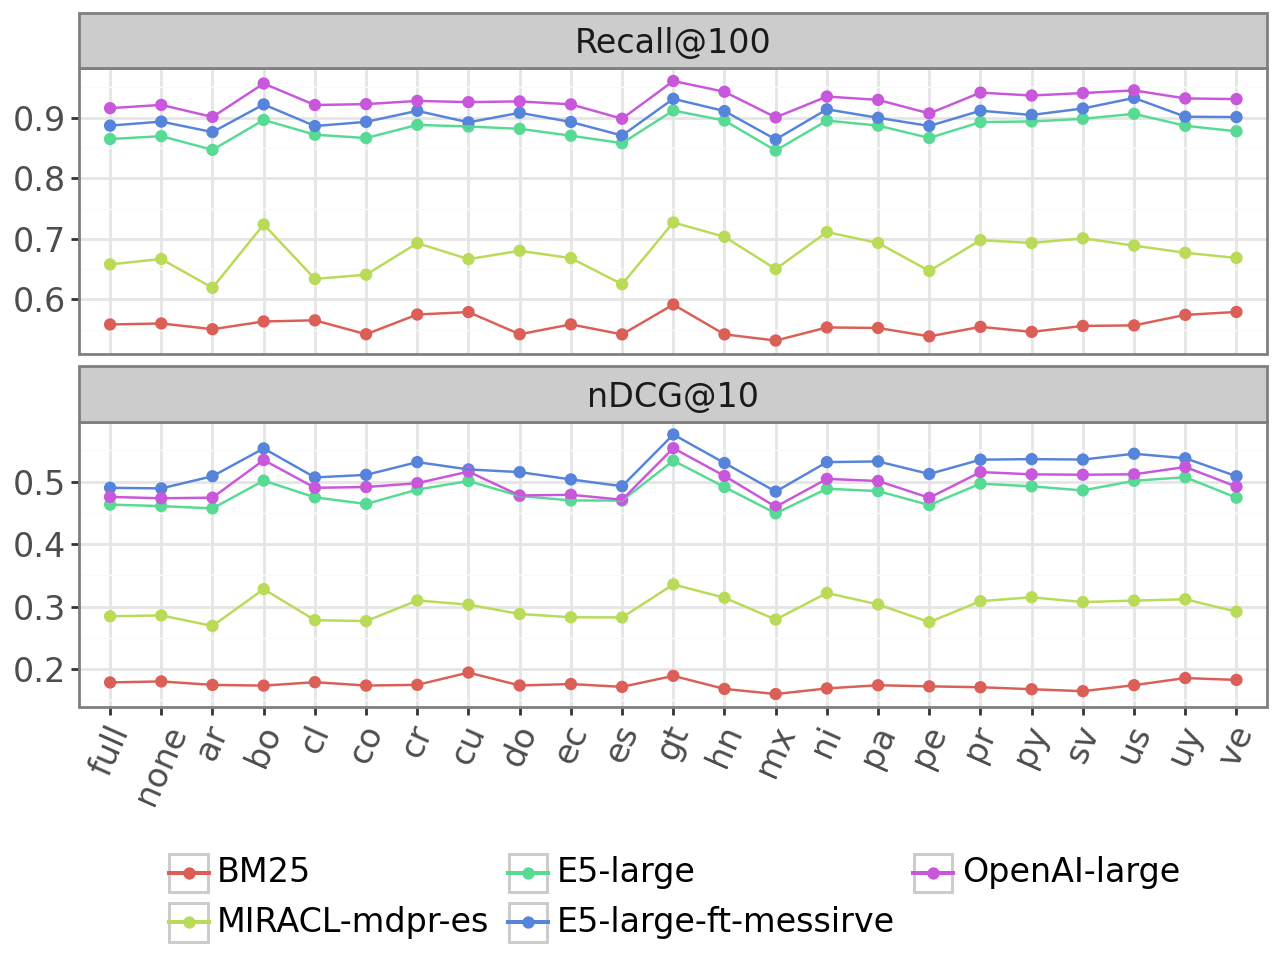

/home/fvalentini/miniconda3/envs/spanish-ir/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5.5 x 4.5 in image.
/home/fvalentini/miniconda3/envs/spanish-ir/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../runs/plots/models_results.pdf


In [7]:
from plotnine import (
    ggplot, aes, geom_point, geom_line, facet_wrap, theme, element_text,
    theme_bw, element_blank, guides, guide_legend, labs
)

df_tmp = df.copy()
df_tmp["country"] = df_tmp["country"].replace("no_country", "none")
df_tmp["metric"] = df_tmp["metric"].map(metric_names_dict)
df_tmp["model"] = df_tmp["model"].map(model_names_dict)

p = (
    ggplot(df_tmp, aes(x="country", y="value", color="model", group="model"))
    + geom_point()
    + geom_line()
    + facet_wrap("~metric", scales="free_y", ncol=1)
    + theme_bw()
    + labs(x="", y="")
    + guides(color=guide_legend(nrow=2))
    + theme(
        legend_position="bottom",
        legend_title=element_blank(),
        axis_text_x=element_text(angle=66, hjust=0.5, size=12),
        # text=element_text(size=12),
        axis_text_y=element_text(size=12),
        legend_text=element_text(size=12),
        strip_text_x=element_text(size=12),
    )
)
p.show()

p.save("../runs/plots/models_results.pdf", width=5.5, height=4.5, dpi=300)


In [8]:
!cp ../runs/plots/models_results.pdf ../latex/plots/